# GameTheory-6-EvolutionTrust

## Evolution de la Confiance et Dilemme du Prisonnier Itere

Ce notebook explore le **Dilemme du Prisonnier Itere** (IPD) et l'evolution de la cooperation, inspire par le travail d'Axelrod et la simulation interactive ["The Evolution of Trust"](https://ncase.me/trust/) de Nicky Case.

### Objectifs

1. Comprendre le Dilemme du Prisonnier Itere
2. Implementer les strategies classiques (Tit-for-Tat, Hawks, Doves...)
3. Reproduire le tournoi d'Axelrod (1984)
4. Simuler l'evolution des populations (replicator dynamics)
5. Identifier les conditions pour l'emergence de la cooperation

### Duree estimee : 65 minutes

### References
- Axelrod, R. (1984). *The Evolution of Cooperation*
- Nicky Case - [The Evolution of Trust](https://ncase.me/trust/)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import List, Tuple, Dict, Callable
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

## 1. Le Dilemme du Prisonnier Itere (IPD)

### Du jeu unique au jeu repete

Dans le Dilemme du Prisonnier **unique**, la strategie dominante est de trahir.

Mais quand le jeu est **repete** (potentiellement indefiniment), la cooperation peut emerger !

### Matrice des gains (convention Axelrod)

|  | Cooperer | Trahir |
|--|----------|--------|
| **Cooperer** | (R, R) = (3, 3) | (S, T) = (0, 5) |
| **Trahir** | (T, S) = (5, 0) | (P, P) = (1, 1) |

- **T** (Temptation) = 5 : Trahir quand l'autre coopere
- **R** (Reward) = 3 : Cooperation mutuelle
- **P** (Punishment) = 1 : Trahison mutuelle
- **S** (Sucker) = 0 : Cooperer quand l'autre trahit

Condition du dilemme : T > R > P > S et 2R > T + S

In [2]:
# Actions
COOPERATE = 'C'
DEFECT = 'D'

# Matrice des gains (convention Axelrod)
T, R, P, S = 5, 3, 1, 0  # Temptation, Reward, Punishment, Sucker

def payoff(action1: str, action2: str) -> Tuple[int, int]:
    """
    Retourne les gains (joueur1, joueur2) pour une paire d'actions.
    """
    if action1 == COOPERATE and action2 == COOPERATE:
        return (R, R)
    elif action1 == COOPERATE and action2 == DEFECT:
        return (S, T)
    elif action1 == DEFECT and action2 == COOPERATE:
        return (T, S)
    else:  # DEFECT, DEFECT
        return (P, P)

# Verification de la condition du dilemme
print(f"Gains: T={T}, R={R}, P={P}, S={S}")
print(f"Condition T > R > P > S: {T > R > P > S}")
print(f"Condition 2R > T + S: {2*R > T + S} ({2*R} > {T+S})")

Gains: T=5, R=3, P=1, S=0
Condition T > R > P > S: True
Condition 2R > T + S: True (6 > 5)


## 2. Strategies classiques

Implementons les strategies les plus connues du tournoi d'Axelrod.

In [3]:
class Strategy(ABC):
    """
    Classe de base pour les strategies IPD.
    """
    
    def __init__(self, name: str = "Strategy"):
        self.name = name
        self.reset()
    
    def reset(self):
        """Reinitialise l'etat interne."""
        self.my_history: List[str] = []
        self.opponent_history: List[str] = []
    
    @abstractmethod
    def choose(self) -> str:
        """Choisit une action basee sur l'historique."""
        pass
    
    def update(self, my_action: str, opponent_action: str):
        """Met a jour l'historique apres un tour."""
        self.my_history.append(my_action)
        self.opponent_history.append(opponent_action)
    
    def __repr__(self):
        return self.name


class AlwaysCooperate(Strategy):
    """Coopere toujours (Dove / Colombe)."""
    
    def __init__(self):
        super().__init__("AlwaysCooperate")
    
    def choose(self) -> str:
        return COOPERATE


class AlwaysDefect(Strategy):
    """Trahit toujours (Hawk / Faucon)."""
    
    def __init__(self):
        super().__init__("AlwaysDefect")
    
    def choose(self) -> str:
        return DEFECT


class TitForTat(Strategy):
    """
    Tit-for-Tat (Copycat / Donnant-donnant).
    
    - Coopere au premier tour
    - Ensuite, copie le dernier coup de l'adversaire
    
    Gagnant du tournoi d'Axelrod (1980).
    """
    
    def __init__(self):
        super().__init__("TitForTat")
    
    def choose(self) -> str:
        if not self.opponent_history:
            return COOPERATE
        return self.opponent_history[-1]


class TitForTwoTats(Strategy):
    """
    Tit-for-Two-Tats (Copykitten / Rancunier indulgent).
    
    - Coopere jusqu'a ce que l'adversaire trahisse DEUX fois de suite
    - Plus indulgent que TFT face aux erreurs
    """
    
    def __init__(self):
        super().__init__("TitForTwoTats")
    
    def choose(self) -> str:
        if len(self.opponent_history) < 2:
            return COOPERATE
        # Trahit seulement si l'adversaire a trahi les 2 derniers tours
        if self.opponent_history[-1] == DEFECT and self.opponent_history[-2] == DEFECT:
            return DEFECT
        return COOPERATE


class Grudger(Strategy):
    """
    Grudger (Rancunier / Grim Trigger).
    
    - Coopere jusqu'a la premiere trahison
    - Apres une trahison, ne pardonne JAMAIS
    """
    
    def __init__(self):
        super().__init__("Grudger")
        self.betrayed = False
    
    def reset(self):
        super().reset()
        self.betrayed = False
    
    def choose(self) -> str:
        if self.betrayed:
            return DEFECT
        return COOPERATE
    
    def update(self, my_action: str, opponent_action: str):
        super().update(my_action, opponent_action)
        if opponent_action == DEFECT:
            self.betrayed = True


class Random(Strategy):
    """Joue aleatoirement avec probabilite p de cooperer."""
    
    def __init__(self, p: float = 0.5):
        super().__init__(f"Random(p={p})")
        self.p = p
    
    def choose(self) -> str:
        return COOPERATE if random.random() < self.p else DEFECT


class Pavlov(Strategy):
    """
    Pavlov (Win-Stay, Lose-Shift).
    
    - Repete l'action si elle a rapporte un bon gain (R ou T)
    - Change sinon
    """
    
    def __init__(self):
        super().__init__("Pavlov")
    
    def choose(self) -> str:
        if not self.my_history:
            return COOPERATE
        
        last_mine = self.my_history[-1]
        last_opp = self.opponent_history[-1]
        
        # Bon resultat (R ou T) -> repeter
        if (last_mine == COOPERATE and last_opp == COOPERATE) or \
           (last_mine == DEFECT and last_opp == COOPERATE):
            return last_mine
        # Mauvais resultat -> changer
        return DEFECT if last_mine == COOPERATE else COOPERATE


class SuspiciousTitForTat(Strategy):
    """TFT mais commence par trahir."""
    
    def __init__(self):
        super().__init__("SuspiciousTFT")
    
    def choose(self) -> str:
        if not self.opponent_history:
            return DEFECT  # Mefiant au debut
        return self.opponent_history[-1]


# Liste des strategies
STRATEGIES = [
    AlwaysCooperate,
    AlwaysDefect,
    TitForTat,
    TitForTwoTats,
    Grudger,
    Random,
    Pavlov,
    SuspiciousTitForTat,
]

print("Strategies implementees:")
for StratCls in STRATEGIES:
    strat = StratCls()
    print(f"  - {strat.name}")

Strategies implementees:
  - AlwaysCooperate
  - AlwaysDefect
  - TitForTat
  - TitForTwoTats
  - Grudger
  - Random(p=0.5)
  - Pavlov
  - SuspiciousTFT


## 3. Simulation d'un match

Simulons des rencontres entre strategies.

In [4]:
def play_match(strategy1: Strategy, strategy2: Strategy, 
               rounds: int = 200, noise: float = 0.0) -> Tuple[int, int]:
    """
    Simule un match entre deux strategies.
    
    Args:
        strategy1, strategy2: Les deux strategies
        rounds: Nombre de tours
        noise: Probabilite d'erreur (action inversee)
    
    Returns:
        (score1, score2)
    """
    strategy1.reset()
    strategy2.reset()
    
    score1, score2 = 0, 0
    
    for _ in range(rounds):
        # Choisir les actions
        action1 = strategy1.choose()
        action2 = strategy2.choose()
        
        # Appliquer le bruit (erreurs de transmission)
        if noise > 0:
            if random.random() < noise:
                action1 = DEFECT if action1 == COOPERATE else COOPERATE
            if random.random() < noise:
                action2 = DEFECT if action2 == COOPERATE else COOPERATE
        
        # Calculer les gains
        p1, p2 = payoff(action1, action2)
        score1 += p1
        score2 += p2
        
        # Mettre a jour les historiques
        strategy1.update(action1, action2)
        strategy2.update(action2, action1)
    
    return score1, score2

# Test: TitForTat vs AlwaysDefect
tft = TitForTat()
defector = AlwaysDefect()

s1, s2 = play_match(tft, defector, rounds=100)
print(f"TitForTat vs AlwaysDefect (100 tours):")
print(f"  TFT: {s1}, Defector: {s2}")

# TitForTat vs TitForTat
tft1 = TitForTat()
tft2 = TitForTat()
s1, s2 = play_match(tft1, tft2, rounds=100)
print(f"\nTitForTat vs TitForTat (100 tours):")
print(f"  TFT1: {s1}, TFT2: {s2}")

TitForTat vs AlwaysDefect (100 tours):
  TFT: 99, Defector: 104

TitForTat vs TitForTat (100 tours):
  TFT1: 300, TFT2: 300


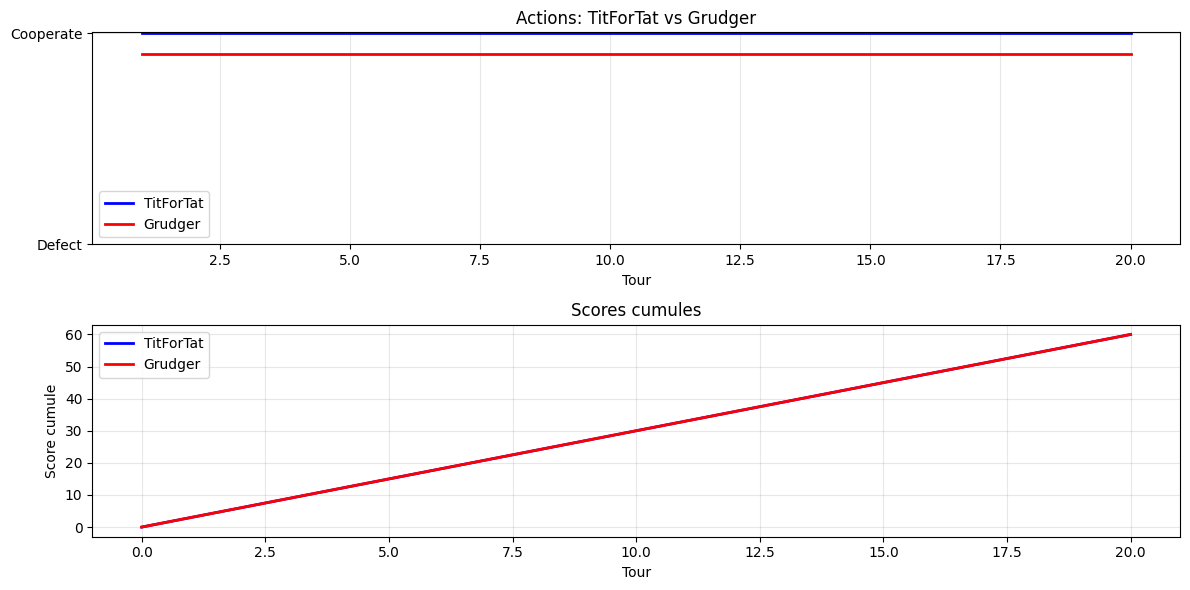

Score final: TitForTat=60, Grudger=60


In [5]:
def visualize_match(strategy1: Strategy, strategy2: Strategy, rounds: int = 30):
    """
    Visualise un match tour par tour.
    """
    strategy1.reset()
    strategy2.reset()
    
    history1, history2 = [], []
    scores1, scores2 = [0], [0]
    
    for _ in range(rounds):
        a1 = strategy1.choose()
        a2 = strategy2.choose()
        
        history1.append(1 if a1 == COOPERATE else 0)
        history2.append(1 if a2 == COOPERATE else 0)
        
        p1, p2 = payoff(a1, a2)
        scores1.append(scores1[-1] + p1)
        scores2.append(scores2[-1] + p2)
        
        strategy1.update(a1, a2)
        strategy2.update(a2, a1)
    
    # Visualisation
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # Actions
    ax = axes[0]
    x = range(1, rounds + 1)
    ax.step(x, history1, 'b-', where='mid', label=strategy1.name, linewidth=2)
    ax.step(x, [h - 0.1 for h in history2], 'r-', where='mid', label=strategy2.name, linewidth=2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Defect', 'Cooperate'])
    ax.set_xlabel('Tour')
    ax.set_title(f'Actions: {strategy1.name} vs {strategy2.name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Scores cumules
    ax = axes[1]
    ax.plot(range(rounds + 1), scores1, 'b-', label=f'{strategy1.name}', linewidth=2)
    ax.plot(range(rounds + 1), scores2, 'r-', label=f'{strategy2.name}', linewidth=2)
    ax.set_xlabel('Tour')
    ax.set_ylabel('Score cumule')
    ax.set_title('Scores cumules')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Score final: {strategy1.name}={scores1[-1]}, {strategy2.name}={scores2[-1]}")

# Visualiser TFT vs Grudger
visualize_match(TitForTat(), Grudger(), rounds=20)

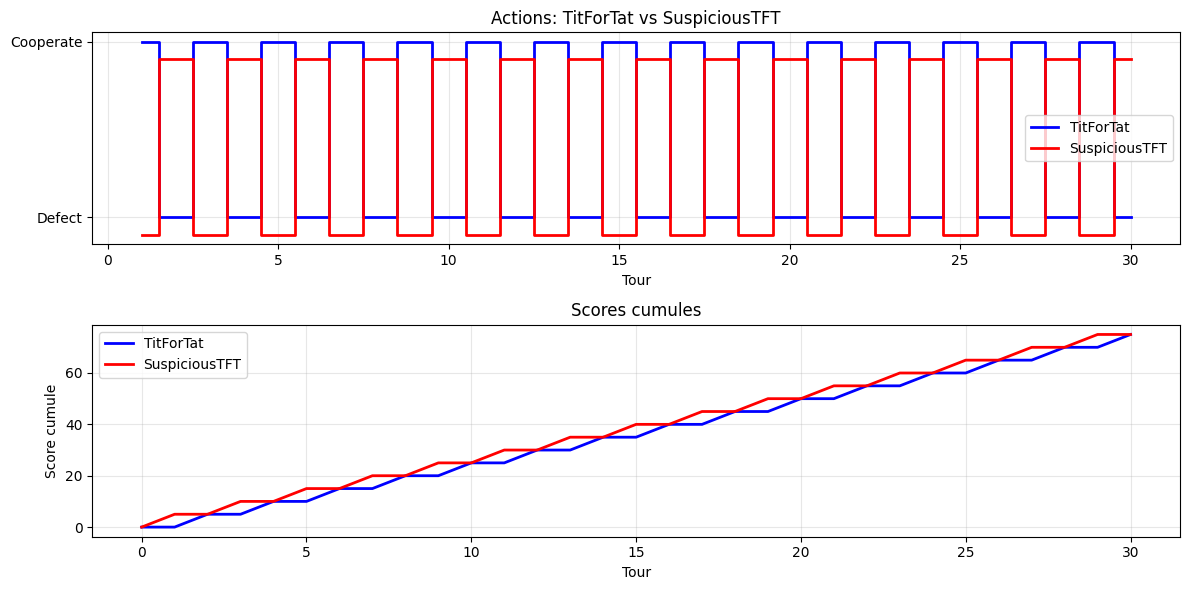

Score final: TitForTat=75, SuspiciousTFT=75


In [6]:
# Visualiser TFT vs SuspiciousTFT
visualize_match(TitForTat(), SuspiciousTitForTat(), rounds=30)

## 4. Tournoi d'Axelrod

Reproduisons le celebre tournoi d'Axelrod (1980) ou chaque strategie affronte toutes les autres.

In [7]:
def run_tournament(strategies: List[Strategy], 
                   rounds: int = 200, 
                   noise: float = 0.0,
                   repetitions: int = 1) -> Dict[str, float]:
    """
    Execute un tournoi round-robin.
    
    Args:
        strategies: Liste des strategies participantes
        rounds: Nombre de tours par match
        noise: Probabilite d'erreur
        repetitions: Nombre de repetitions pour moyenner (utile avec bruit)
    
    Returns:
        Dictionnaire {nom_strategie: score_moyen_par_match}
    """
    n = len(strategies)
    scores = defaultdict(float)
    match_count = defaultdict(int)
    
    for _ in range(repetitions):
        for i in range(n):
            for j in range(n):
                # Creer des instances fraiches
                s1 = type(strategies[i])()
                s2 = type(strategies[j])()
                
                score1, score2 = play_match(s1, s2, rounds, noise)
                
                scores[strategies[i].name] += score1
                scores[strategies[j].name] += score2
                match_count[strategies[i].name] += 1
                match_count[strategies[j].name] += 1
    
    # Calculer la moyenne par match
    avg_scores = {name: scores[name] / match_count[name] for name in scores}
    
    return avg_scores

def display_tournament_results(results: Dict[str, float], title: str = "Tournoi"):
    """Affiche les resultats du tournoi."""
    sorted_results = sorted(results.items(), key=lambda x: -x[1])
    
    print(f"\n{title}")
    print("=" * 50)
    print(f"{'Rang':<5} {'Strategie':<20} {'Score moyen':<12}")
    print("-" * 50)
    
    for rank, (name, score) in enumerate(sorted_results, 1):
        print(f"{rank:<5} {name:<20} {score:<12.2f}")

# Creer les instances
tournament_strategies = [StratCls() for StratCls in STRATEGIES]

# Tournoi sans bruit
results = run_tournament(tournament_strategies, rounds=200, noise=0.0)
display_tournament_results(results, "Tournoi d'Axelrod (sans bruit)")


Tournoi d'Axelrod (sans bruit)
Rang  Strategie            Score moyen 
--------------------------------------------------
1     TitForTwoTats        521.88      
2     TitForTat            518.56      
3     Grudger              497.12      
4     Pavlov               494.56      
5     AlwaysCooperate      487.12      
6     Random(p=0.5)        426.12      
7     AlwaysDefect         401.50      
8     SuspiciousTFT        392.19      


In [8]:
# Tournoi avec bruit (5% d'erreurs)
results_noisy = run_tournament(tournament_strategies, rounds=200, noise=0.05, repetitions=10)
display_tournament_results(results_noisy, "Tournoi avec bruit (5% d'erreurs)")


Tournoi avec bruit (5% d'erreurs)
Rang  Strategie            Score moyen 
--------------------------------------------------
1     TitForTwoTats        445.43      
2     Pavlov               439.74      
3     TitForTat            435.57      
4     Random(p=0.5)        432.45      
5     SuspiciousTFT        432.11      
6     Grudger              430.99      
7     AlwaysDefect         425.78      
8     AlwaysCooperate      382.19      


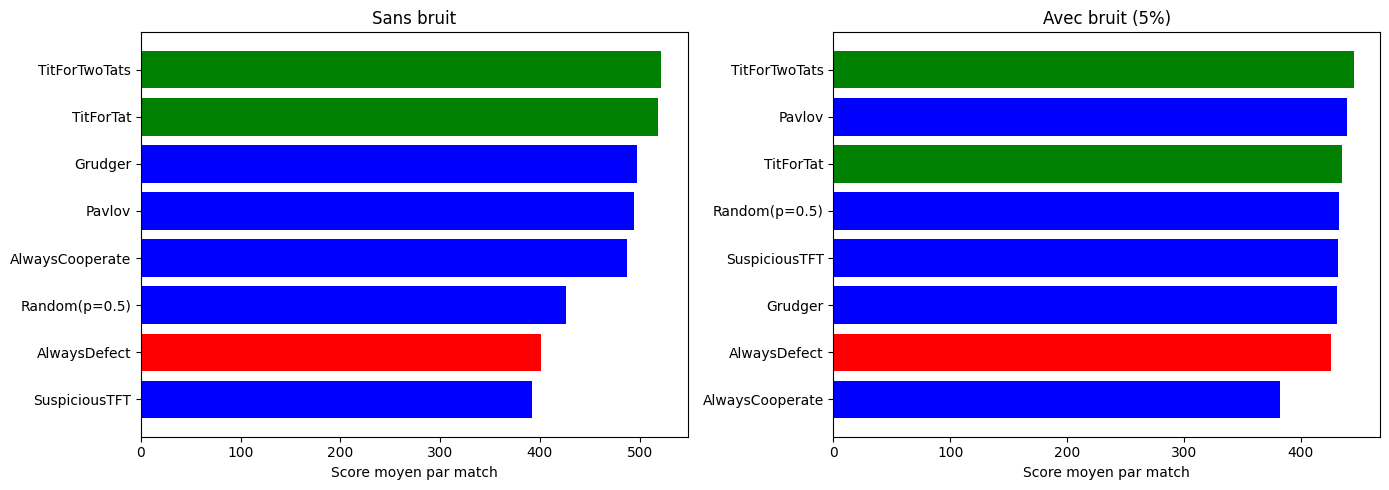

In [9]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, res, title in [(axes[0], results, 'Sans bruit'), 
                        (axes[1], results_noisy, 'Avec bruit (5%)')]:
    names = list(res.keys())
    scores = list(res.values())
    
    sorted_idx = np.argsort(scores)[::-1]
    names = [names[i] for i in sorted_idx]
    scores = [scores[i] for i in sorted_idx]
    
    colors = ['green' if 'TitFor' in n else 'red' if 'Defect' in n else 'blue' for n in names]
    
    ax.barh(range(len(names)), scores, color=colors)
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names)
    ax.set_xlabel('Score moyen par match')
    ax.set_title(title)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

### Observations d'Axelrod

Les strategies gagnantes partagent plusieurs proprietes :

1. **Nice** (Gentilles) : Ne jamais trahir en premier
2. **Retaliating** (Retorsion) : Punir les trahisons
3. **Forgiving** (Pardonner) : Revenir a la cooperation apres punition
4. **Clear** (Claire) : Comportement previsible

## 5. Dynamique des populations (Replicator Dynamics)

Comment evoluent les populations de strategies au fil du temps ?

In [10]:
def compute_payoff_matrix(strategies: List[Strategy], rounds: int = 200) -> np.ndarray:
    """
    Calcule la matrice des gains moyens entre strategies.
    
    M[i,j] = gain moyen de strategie i contre strategie j
    """
    n = len(strategies)
    M = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            s1 = type(strategies[i])()
            s2 = type(strategies[j])()
            score1, _ = play_match(s1, s2, rounds)
            M[i, j] = score1 / rounds  # Gain moyen par tour
    
    return M

def replicator_dynamics(M: np.ndarray, x0: np.ndarray, 
                        T: int = 100, dt: float = 0.1) -> np.ndarray:
    """
    Simule la dynamique du replicateur.
    
    dx_i/dt = x_i * (fitness_i - fitness_moyenne)
    
    Args:
        M: Matrice des gains
        x0: Distribution initiale des strategies
        T: Nombre d'iterations
        dt: Pas de temps
    
    Returns:
        Trajectoire des proportions (T x n)
    """
    n = len(x0)
    trajectory = np.zeros((T, n))
    x = x0.copy()
    
    for t in range(T):
        trajectory[t] = x
        
        # Fitness de chaque strategie
        fitness = M @ x
        
        # Fitness moyenne
        avg_fitness = x @ fitness
        
        # Equation du replicateur
        dx = x * (fitness - avg_fitness) * dt
        x = x + dx
        
        # Normaliser (pour stabilite numerique)
        x = np.maximum(x, 0)
        x = x / np.sum(x)
    
    return trajectory

# Calculer la matrice des gains
simple_strategies = [TitForTat(), AlwaysCooperate(), AlwaysDefect()]
M = compute_payoff_matrix(simple_strategies, rounds=200)

print("Matrice des gains moyens par tour:")
print(f"{'':15}", end="")
for s in simple_strategies:
    print(f"{s.name:>15}", end="")
print()
for i, s in enumerate(simple_strategies):
    print(f"{s.name:15}", end="")
    for j in range(len(simple_strategies)):
        print(f"{M[i,j]:>15.2f}", end="")
    print()

Matrice des gains moyens par tour:
                     TitForTatAlwaysCooperate   AlwaysDefect
TitForTat                 3.00           3.00           0.99
AlwaysCooperate           3.00           3.00           0.00
AlwaysDefect              1.02           5.00           1.00


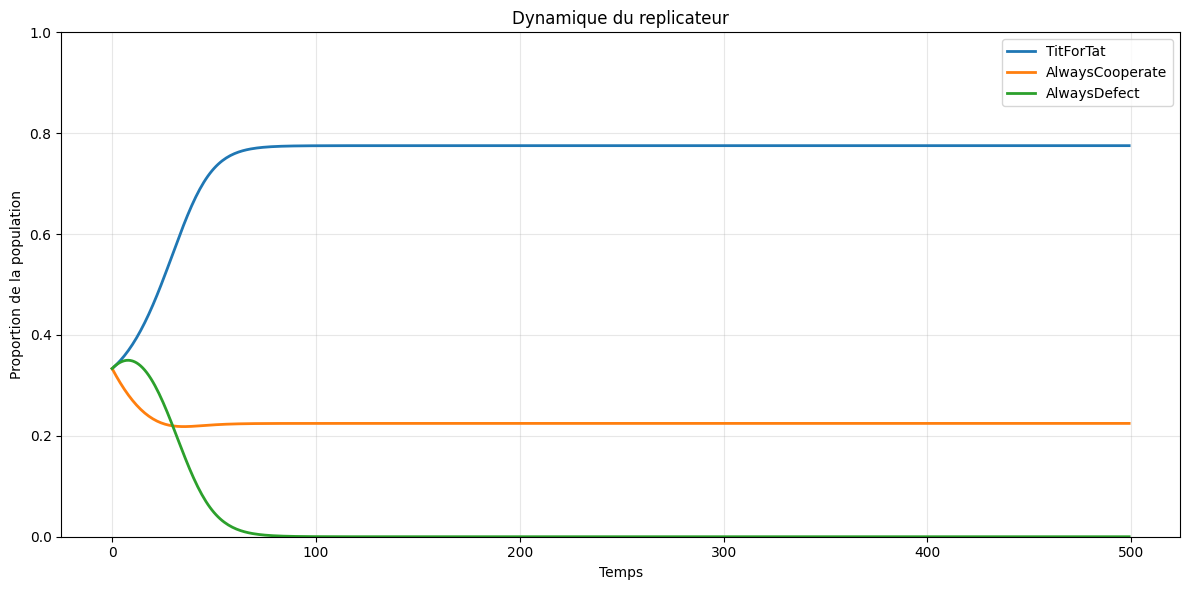


Etat final:
  TitForTat: 77.5%
  AlwaysCooperate: 22.5%
  AlwaysDefect: 0.0%


In [11]:
def plot_replicator_dynamics(strategies: List[Strategy], 
                              x0: np.ndarray = None,
                              T: int = 500):
    """
    Visualise l'evolution des populations.
    """
    n = len(strategies)
    M = compute_payoff_matrix(strategies, rounds=200)
    
    if x0 is None:
        x0 = np.ones(n) / n  # Distribution uniforme
    
    trajectory = replicator_dynamics(M, x0, T=T, dt=0.1)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, s in enumerate(strategies):
        ax.plot(trajectory[:, i], label=s.name, linewidth=2)
    
    ax.set_xlabel('Temps')
    ax.set_ylabel('Proportion de la population')
    ax.set_title('Dynamique du replicateur')
    ax.legend(loc='best')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Etat final
    print("\nEtat final:")
    for i, s in enumerate(strategies):
        print(f"  {s.name}: {trajectory[-1, i]*100:.1f}%")

# Evolution: TFT vs Cooperators vs Defectors
plot_replicator_dynamics(simple_strategies)

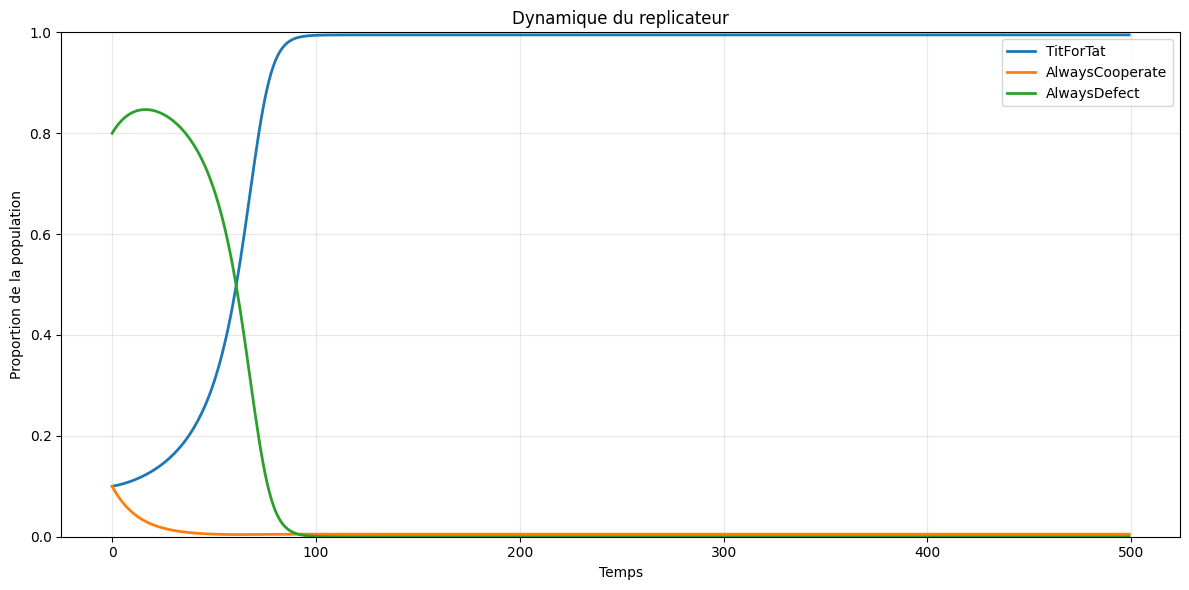


Etat final:
  TitForTat: 99.5%
  AlwaysCooperate: 0.5%
  AlwaysDefect: 0.0%


In [12]:
# Avec conditions initiales differentes
# Beaucoup de defecteurs au debut
plot_replicator_dynamics(simple_strategies, x0=np.array([0.1, 0.1, 0.8]))

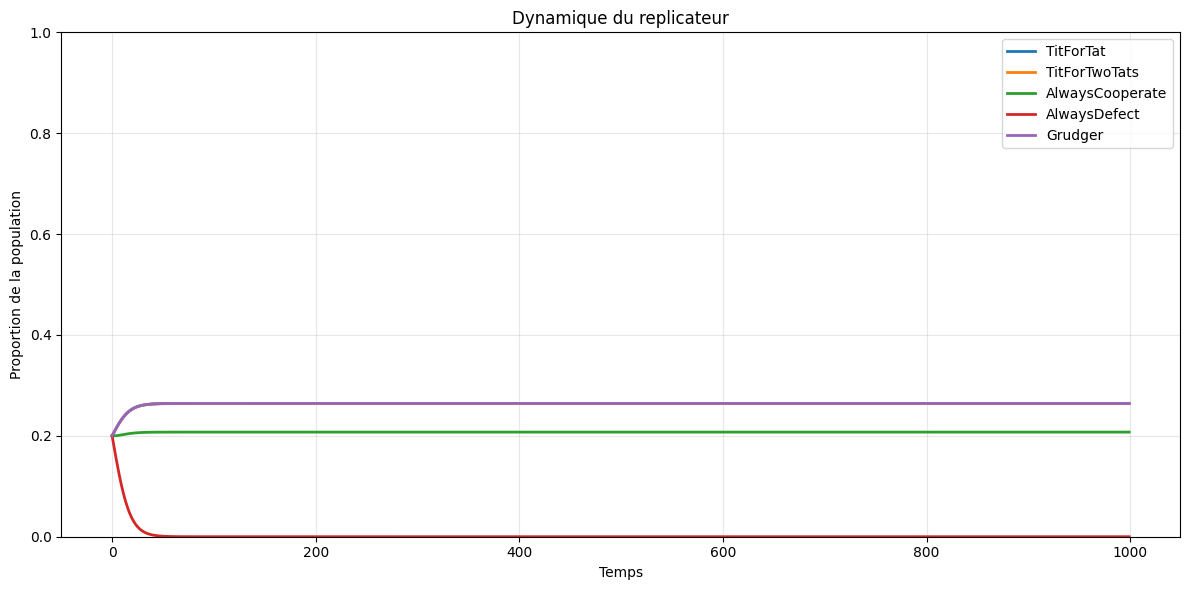


Etat final:
  TitForTat: 26.4%
  TitForTwoTats: 26.4%
  AlwaysCooperate: 20.7%
  AlwaysDefect: 0.0%
  Grudger: 26.4%


In [13]:
# Evolution plus complexe avec plus de strategies
complex_strategies = [
    TitForTat(),
    TitForTwoTats(),
    AlwaysCooperate(),
    AlwaysDefect(),
    Grudger(),
]

plot_replicator_dynamics(complex_strategies, T=1000)

## 6. Conditions pour la cooperation

Quand la cooperation peut-elle emerger et persister ?

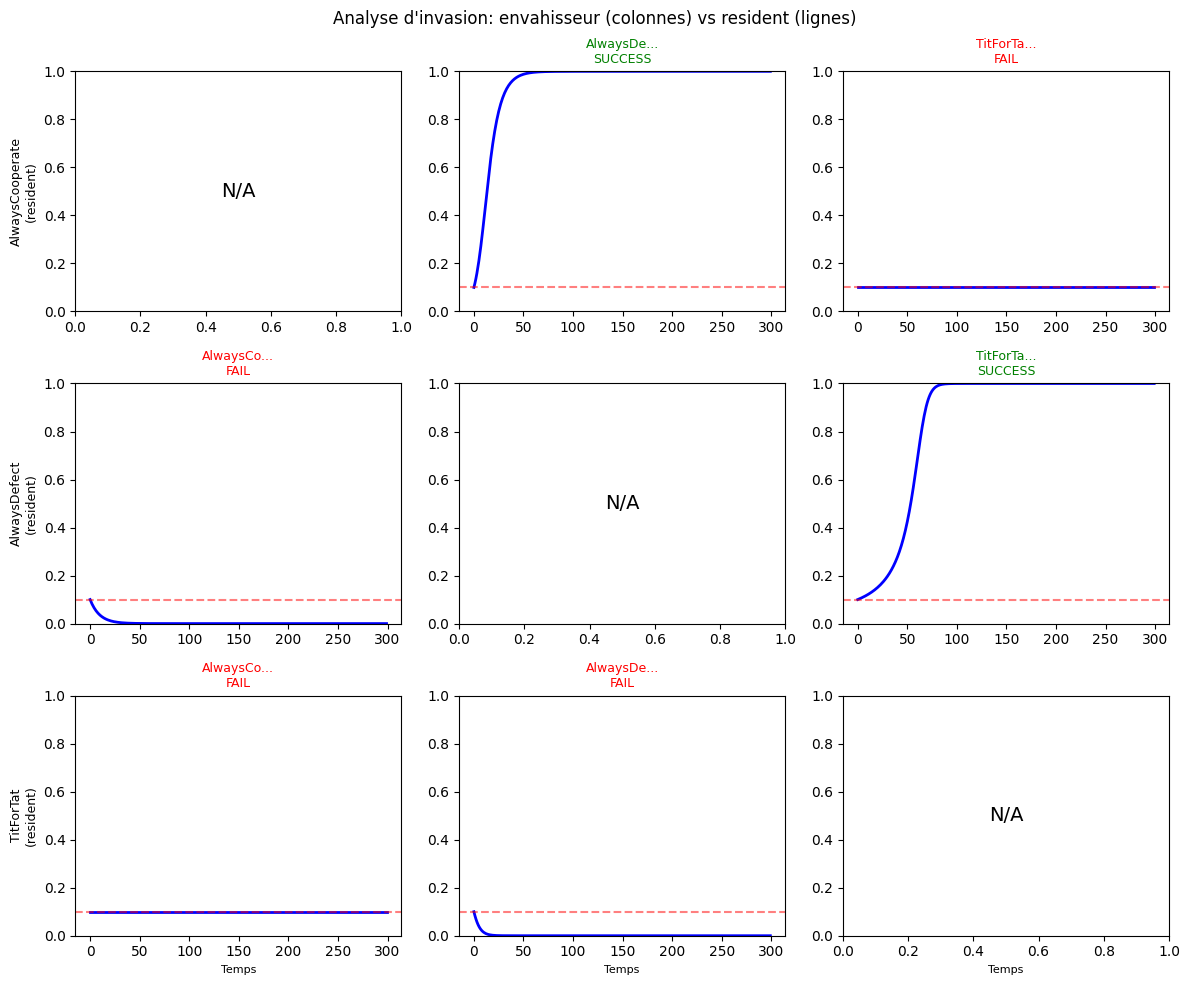

In [14]:
def analyze_invasion(resident: Strategy, invader: Strategy, 
                     invasion_rate: float = 0.1, 
                     T: int = 500) -> Tuple[np.ndarray, bool]:
    """
    Analyse si un envahisseur peut envahir une population residente.
    
    Args:
        resident: Strategie residente
        invader: Strategie envahissante
        invasion_rate: Proportion initiale d'envahisseurs
    
    Returns:
        (trajectory, invasion_successful)
    """
    M = compute_payoff_matrix([resident, invader], rounds=200)
    x0 = np.array([1 - invasion_rate, invasion_rate])
    
    trajectory = replicator_dynamics(M, x0, T=T, dt=0.1)
    
    # Invasion reussie si la proportion d'envahisseurs augmente
    success = trajectory[-1, 1] > invasion_rate * 2
    
    return trajectory, success

def plot_invasion_analysis():
    """
    Analyse les possibilites d'invasion entre strategies.
    """
    strategies = [AlwaysCooperate(), AlwaysDefect(), TitForTat()]
    n = len(strategies)
    
    fig, axes = plt.subplots(n, n, figsize=(12, 10))
    
    for i, resident in enumerate(strategies):
        for j, invader in enumerate(strategies):
            ax = axes[i, j]
            
            if i == j:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
            else:
                traj, success = analyze_invasion(type(resident)(), type(invader)(), T=300)
                
                ax.plot(traj[:, 1], 'b-', linewidth=2)
                ax.axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
                ax.set_ylim(0, 1)
                
                result = "SUCCESS" if success else "FAIL"
                color = 'green' if success else 'red'
                ax.set_title(f'{invader.name[:8]}...\n{result}', fontsize=9, color=color)
            
            if i == n-1:
                ax.set_xlabel('Temps', fontsize=8)
            if j == 0:
                ax.set_ylabel(f'{resident.name}\n(resident)', fontsize=9)
    
    fig.suptitle('Analyse d\'invasion: envahisseur (colonnes) vs resident (lignes)', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_invasion_analysis()

### Observations

- **AlwaysDefect** peut envahir **AlwaysCooperate** facilement
- **TitForTat** resiste a l'invasion par **AlwaysDefect**
- **TitForTat** peut envahir **AlwaysDefect** s'il y a suffisamment de TFT

La cooperation peut emerger si les cooperateurs peuvent se **reconnaitre** et interagir preferentiellement entre eux.

## 7. Impact du bruit

Comment le bruit (erreurs) affecte-t-il les strategies ?

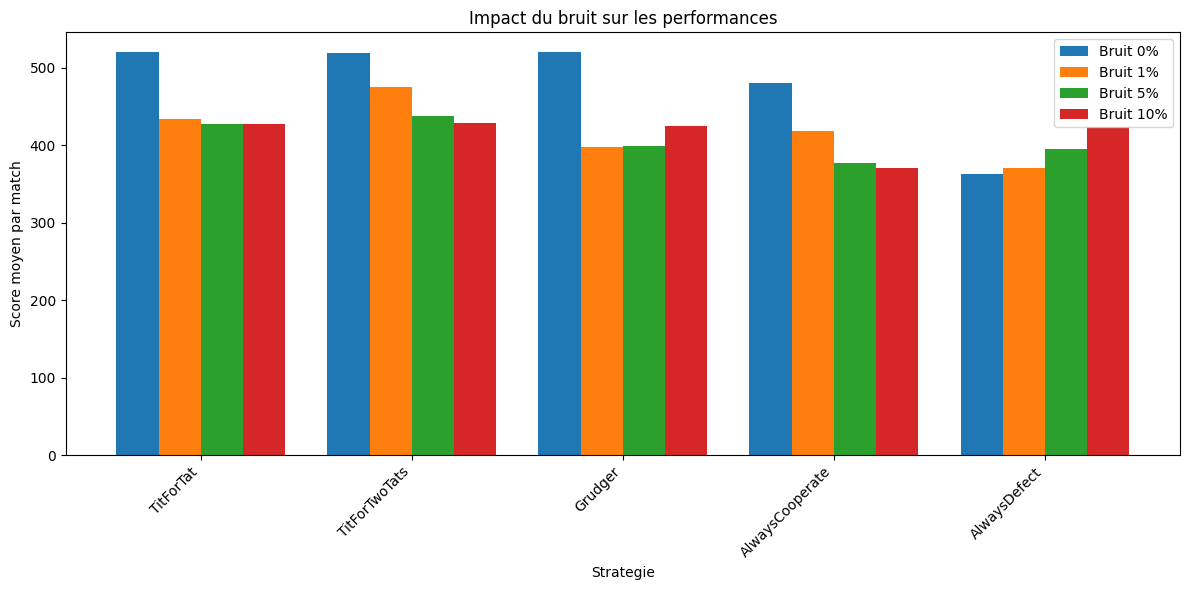

In [15]:
def compare_noise_impact(strategies: List[Strategy], 
                         noise_levels: List[float] = [0, 0.01, 0.05, 0.1]):
    """
    Compare les performances des strategies a differents niveaux de bruit.
    """
    results = {}
    
    for noise in noise_levels:
        tournament_results = run_tournament(strategies, rounds=200, 
                                            noise=noise, repetitions=20)
        results[noise] = tournament_results
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(strategies))
    width = 0.2
    
    for i, noise in enumerate(noise_levels):
        scores = [results[noise][s.name] for s in strategies]
        ax.bar(x + i*width, scores, width, label=f'Bruit {noise*100:.0f}%')
    
    ax.set_xlabel('Strategie')
    ax.set_ylabel('Score moyen par match')
    ax.set_title('Impact du bruit sur les performances')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels([s.name for s in strategies], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Comparer l'impact du bruit
test_strategies = [TitForTat(), TitForTwoTats(), Grudger(), AlwaysCooperate(), AlwaysDefect()]
compare_noise_impact([type(s)() for s in test_strategies])

### Observations sur le bruit

- **TitForTat** souffre du bruit : une erreur peut declencher une spirale de represailles
- **TitForTwoTats** (Copykitten) est plus robuste au bruit car il pardonne une erreur
- **Grudger** est devastateur avec le bruit : une seule erreur = fin de la cooperation

## 8. Resume

### Strategies et leurs proprietes

| Strategie | Nice | Retaliating | Forgiving | Robuste au bruit |
|-----------|------|-------------|-----------|------------------|
| **TitForTat** | Oui | Oui | Oui | Non |
| **TitForTwoTats** | Oui | Oui | Tres | Oui |
| **Grudger** | Oui | Oui | Non | Non |
| **AlwaysCooperate** | Oui | Non | N/A | Oui |
| **AlwaysDefect** | Non | N/A | N/A | Oui |
| **Pavlov** | Oui | Variable | Variable | Moyen |

### Lecons d'Axelrod

1. **Soyez gentil** : Ne trahissez pas en premier
2. **Soyez provoquable** : Punissez les trahisons
3. **Soyez indulgent** : Pardonnez apres punition
4. **Soyez clair** : Comportement previsible

### Conditions pour la cooperation

- **Repetition** : Le jeu doit etre repete (ombre du futur)
- **Reconnaissance** : Les cooperateurs doivent pouvoir se reconnaitre
- **Clustering** : Les cooperateurs beneficient d'interactions preferentielles
- **Robustesse** : La strategie doit resister au bruit

## 9. Exercices

### Exercice 1
Implementez la strategie "Generous TitForTat" qui pardonne avec probabilite 10% meme apres une trahison.

### Exercice 2
Simulez un tournoi avec 20% de "bruit structurel" (certains joueurs font toujours des erreurs).

### Exercice 3
Explorez l'effet de la taille de la population sur l'evolution des strategies.

In [16]:
# Espace pour les exercices

# Exercice 1: Generous TitForTat
class GenerousTitForTat(Strategy):
    """TFT avec pardon aleatoire."""
    
    def __init__(self, forgiveness: float = 0.1):
        super().__init__(f"GenTFT(p={forgiveness})")
        self.forgiveness = forgiveness
    
    def choose(self) -> str:
        if not self.opponent_history:
            return COOPERATE
        
        if self.opponent_history[-1] == DEFECT:
            # Pardonner avec probabilite forgiveness
            if random.random() < self.forgiveness:
                return COOPERATE
            return DEFECT
        
        return COOPERATE

# Tester
# ...

---

**Notebook precedent**: [GameTheory-5-ZeroSum-Minimax](GameTheory-5-ZeroSum-Minimax.ipynb)  
**Notebook suivant**: [GameTheory-7-ExtensiveForm](GameTheory-7-ExtensiveForm.ipynb)